In [27]:
import sys
import os
import math
import warnings
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yfinance as yf


sys.path.append(os.path.abspath(".."))
from lags import build_ar_lag_matrix

In [28]:
# Hyperparams

START_DATE = "2023-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")
TICKER = "LTC-USD"
P = 5 # orden AR
TEST_FRACTION = 0.3 # 20% para test

In [29]:
# Lectura

df = yf.download("LTC-USD", start=START_DATE, end=END_DATE, interval="1d", auto_adjust=True, progress=False)
df = df[["Close"]].dropna()
df.index = pd.to_datetime(df.index)
y = df["Close"].astype(float).values
dates = df.index.to_numpy()

In [30]:
# Train-Test Split

N = len(y)
test_size = max(P + 1, int(np.ceil(TEST_FRACTION * N))) 
train_size = N - test_size
y_train = y[:train_size]
y_test  = y[train_size:]
dates_test = dates[train_size:]

print(f'training until {pd.to_datetime(dates[train_size-1]).strftime("%Y-%m-%d")}, {train_size} samples')

training until 2024-12-03, 703 samples


In [31]:
# Construcción de la matriz de diseño

X_train = np.column_stack([y_train[P - k - 1: len(y_train) - k - 1] for k in range(P)])
y_target = y_train[P:]

In [32]:
# Regresión Lineal

X_design = np.column_stack([np.ones(len(X_train)), X_train])
beta, *_ = np.linalg.lstsq(X_design, y_target, rcond=None)
beta   = np.asarray(beta, dtype=float).ravel()
intercept = float(beta[0])
coefs  = beta[1:].ravel()

In [33]:
preds = np.full(N, np.nan)
lags = y_train[-P:][::-1]  # ultimos 5 de y_train
for t in range(train_size, N):
    preds[t] = intercept + np.dot(coefs, lags)
    lags = np.append(preds[t], lags[:-1]) # actualizar lags

y_pred_test = preds[train_size:]

MAE = float(np.mean(np.abs(y_test - y_pred_test)))
RMSE = float(np.sqrt(np.mean((y_test - y_pred_test) ** 2)))
print(f"Samples: total={N}, train={train_size}, test={test_size}, AR order={P}")
print(f"Test MAE:  {MAE:,.4f}")
print(f"Test RMSE: {RMSE:,.4f}")

Samples: total=1005, train=703, test=302, AR order=5
Test MAE:  17.7799
Test RMSE: 21.9294


/var/folders/w5/kmvyzkpj2q1fyf7tnn3nqwb40000gn/T/ipykernel_19673/3895261093.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds[t] = intercept + np.dot(coefs, lags)


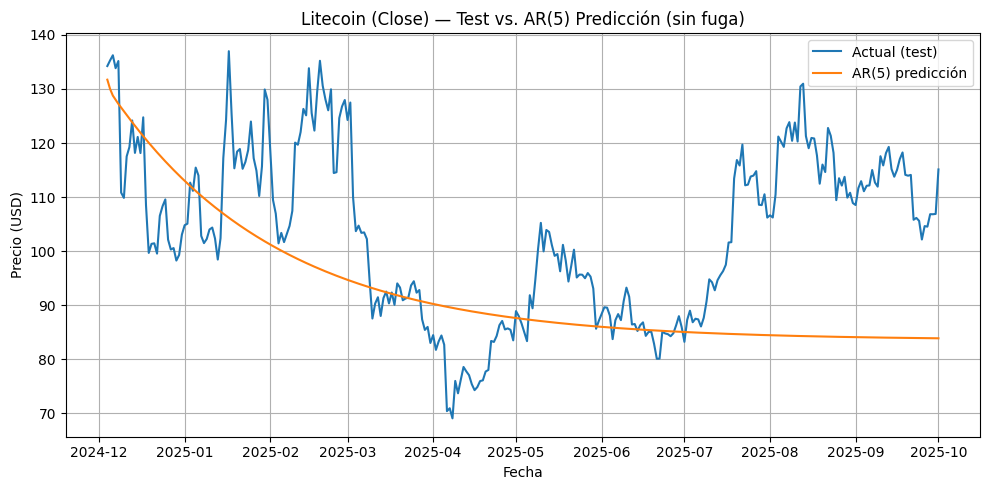

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(dates_test, y_test, label="Actual (test)")
plt.plot(dates_test, y_pred_test, label="AR(5) predicción")
plt.legend()
plt.title("Litecoin (Close) — Test vs. AR(5) Predicción")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.tight_layout()
plt.grid()
plt.show()